In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier

/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# movies = pd.read_csv('./data/tmdb_5000_movies.csv').head(n=1)
# credits = pd.read_csv('./data/tmdb_5000_credits.csv').head(n=1)
movies = pd.read_csv('./data/tmdb_5000_movies.csv')
credits = pd.read_csv('./data/tmdb_5000_credits.csv')

### Create list of all actors

In [3]:
%run -i clean-movies.py

In [4]:
unique_actors_count = pd.crosstab(actors, columns='count')

unique_actors_count \
.sort_values(by='count', ascending=False).head(12)

col_0,count
row_0,
Samuel L. Jackson - 2231,67
Robert De Niro - 380,57
Bruce Willis - 62,51
Matt Damon - 1892,48
Morgan Freeman - 192,46
Steve Buscemi - 884,43
Liam Neeson - 3896,41
Johnny Depp - 85,40
Owen Wilson - 887,40


#### Total Number of unique actors

In [5]:
len(unique_actors_count)

54588

#### Total Number of actors that show up more than once

In [6]:
len(unique_actors_count[unique_actors_count.values > 1])

15661

#### Total Number of actors that show up more than three times

In [7]:
len(unique_actors_count[unique_actors_count.values > 3])

5326

In [8]:
sam_count = unique_actors_count[unique_actors_count.index == 'Samuel L. Jackson - 2231']
sam_count

col_0,count
row_0,
Samuel L. Jackson - 2231,67


In [9]:
sam_count.values[0][0]

67

### Create Actors Features

## Actor Vectorization

### label records as having Any Star (top 5 high performers)

In [10]:
stars = [
    get_actor_feature_name('2231'), # Samuel L. Jackson
    get_actor_feature_name('380'),  # Robert De Niro
    get_actor_feature_name('62'),   # Bruce Willis
    get_actor_feature_name('1892'), # Matt Damon
    get_actor_feature_name('192'),  # Morgan Freeman
]
movies['stars'] = actor_vector_works[stars].any(axis='columns')
movies_with_stars = movies[movies.stars == True]
len(movies_with_stars)

257

### label records as having Samuel L. Jackson

In [11]:
movies_with_samuel = movies[movies.samuel == True]

#### There should be 67 movies with Samuel L Jackson

In [12]:
len(movies_with_samuel)

67

In [13]:
baseline_prediction = len(movies_with_stars) / len(movies)
1 - baseline_prediction

0.94649177597335

# Genres

### All Unique Genres

In [14]:
unique_genres(movies.genres)

Drama              2297
Comedy             1722
Thriller           1274
Action             1154
Romance             894
Adventure           790
Crime               696
Science Fiction     535
Horror              519
Family              513
Fantasy             424
Mystery             348
Animation           234
History             197
Music               185
War                 144
Documentary         110
Western              82
Foreign              34
TV Movie              8
dtype: int64

### Genres which Samuel is in

In [15]:
movies_merge = pd.merge(left=movies, right=actor_vector_works, left_on='id', right_on='id')
movies_with_samuel = movies_merge[movies_merge[get_actor_feature_name('2231')] == 1]
unique_genres(movies_with_samuel['genres'])

Action             35
Crime              25
Thriller           25
Drama              25
Adventure          20
Science Fiction    17
Comedy             13
Mystery             8
Romance             7
Animation           4
Family              4
Western             2
Documentary         2
Horror              2
Music               2
Fantasy             2
War                 1
dtype: int64

### Genres which The Stars are in

In [16]:
movies_with_stars = movies_merge[movies_merge[stars].any(axis='columns')]
unique_genres(movies_with_stars['genres'])

Drama              116
Thriller           103
Action              96
Crime               85
Comedy              74
Adventure           52
Science Fiction     38
Mystery             27
Romance             26
Family              22
Animation           15
Fantasy             14
War                  9
Horror               6
Western              6
Documentary          5
History              5
Music                3
dtype: int64

### Number of genres in movie

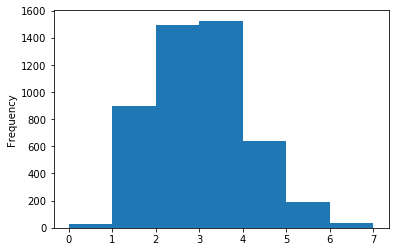

In [17]:
number_genres = movies.genres.apply(len)
number_genres.plot.hist(bins=np.max(number_genres))
plt.show()

### Normalize Movie Features

In [18]:
features_to_normalize = [
    'budget',
    'popularity',
    'vote_average',
    'vote_count',
    'revenue'
]

In [19]:
for feature in features_to_normalize:
    feature_array = movies[feature].values.astype('float64').reshape(1, -1)
    movies[feature + '_original'] =     movies[feature]
    movies[feature] = normalize(feature_array, axis=1, norm='max')[0]

In [20]:
movies[features_to_normalize].head(n=1)

,budget,popularity,vote_average,vote_count,revenue
0,0.623684,0.171815,0.72,0.858057,1.0


# Create x/y

In [21]:
len(actor_vector_works)

4803

In [22]:
x = pd.read_csv('data/movies_x_train.csv')
y = pd.read_csv('data/movies_y_train.csv', header=None)

In [23]:
### Remove id as a feature
x = x[x.columns.difference(['id'])]

### Remove "Stars" from actors

In [24]:
#def remove_samuel(x):
    #return x[x.columns.difference(stars)]
#x = remove_samuel(x)
#len(x.columns)

x = x[x.columns.difference([get_actor_feature_name('2231')])]

### Create Cross-validation (10% holdout)

In [25]:
len(x)

4381

In [26]:
len(y)

4381

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.1, random_state=3, stratify=y)

In [28]:
X_train.shape, y_train.shape

((3942, 5344), (3942, 1))

## Get Accuracy

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools

In [30]:
def show_confusion_matrix(y, predict_true, x):
    cm = confusion_matrix(y, predict_true)
    cm = pd.DataFrame(cm)
    cm.columns = ['Negative', 'Positive']
    cm.index = ['Negative', 'Positive']
    print(cm)
    
    return
    cmap=plt.cm.Blues
    classes = x.columns
    tick_marks = np.arange(len(classes))
    title = 'Confusion Matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [31]:
def get_accuracy(model, x, y):
    predict_true = np.zeros(len(y))
    if hasattr(model, 'predict_classes'):
        predict_true = model.predict_classes(x)
    elif hasattr(model, 'predict'):
        predict_true = model.predict(x)
    else:
        predict_true = model.fit_predict(x)
    print('Number of positive predictions {}'.format(len(predict_true[predict_true == True])))
    print('')
    print('Accuracy {}'.format(accuracy_score(y, predict_true)))
    print('')
    show_confusion_matrix(y, predict_true, x)

# Naive Bayes Classifications

In [32]:
bayes_model = MultinomialNB()
bayes_model.fit(X_train, y_train)

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [33]:
print('Accuracy of Training Data')
get_accuracy(bayes_model, X_train, y_train)

Accuracy of Training Data
Number of positive predictions 90

Accuracy 0.9901065449010654

          Negative  Positive
Negative      3822         9
Positive        30        81


In [34]:
print('Accuracy of Test Data')
get_accuracy(bayes_model, X_test, y_test)

Accuracy of Test Data
Number of positive predictions 17

Accuracy 0.9703872437357631

          Negative  Positive
Negative       418         9
Positive         4         8


# Deep Learning (Dense Layers)

In [35]:
from keras import models, layers

Using TensorFlow backend.


In [36]:
model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dropout(.2))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [37]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 42760     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
__________

In [38]:
model.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
3942/3942 [==============================] - 1s 252us/step - loss: 0.3803 - acc: 0.8445
Epoch 2/10
394

In [39]:
get_accuracy(model, X_test, y_test)

Number of positive predictions 9

Accuracy 0.9886104783599089

          Negative  Positive
Negative       426         1
Positive         4         8


In [40]:
import time
model_file = 'data/movies_models/samuel_movies{}.h5'.format(time.time())
model.save(model_file)
print('saving {}'.format(model_file))

saving data/movies_models/samuel_movies1533444486.458372.h5


### Hierarchical Clustering

In [41]:
#from sklearn.cluster import AgglomerativeClustering
#cluster_model = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='complete')
#cluster_model.fit(X_train, y_train)

In [42]:
#print('Accuracy of Training Data')
#get_accuracy(cluster_model, X_train, y_train)

In [43]:
#print('Accuracy of Test Data')
#get_accuracy(cluster_model, X_test, y_test)

# Shap

In [44]:
# import shap

In [45]:
# explainer = shap.KernelExplainer(model.predict_proba, X_train, link="logit")
# shap_values = explainer.shap_values(X_test, nsamples=100)


# Determine Feature Importance

In [46]:
np.random.seed(20)

In [47]:
random_forest = RandomForestClassifier()

In [48]:
random_forest.fit(X_train, y_train)

clean-movies.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import pandas as pd


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [49]:
features_names = x.columns
features_importance = random_forest.feature_importances_

In [50]:
feature_rank_df = pd.DataFrame({
    'features_importance': features_importance,
    'features_names': features_names,
}, index = features_names)

In [51]:
top_twenty_features = feature_rank_df \
    .sort_values(by=['features_importance'], ascending=False)[0:20] \
    .sort_values(by=['features_importance'])

### Top Ten Features

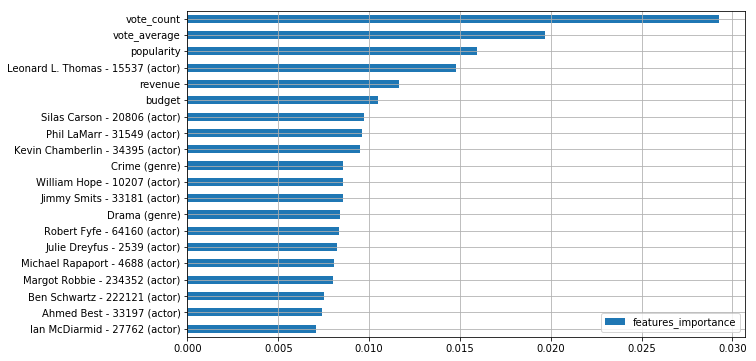

In [52]:
top_twenty_features.plot.barh(grid=True, figsize=(10, 6))
plt.show()

### Distribution of feature importance

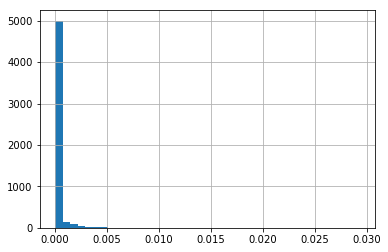

In [53]:
feature_rank_df.features_importance.hist(bins=40)
plt.show()

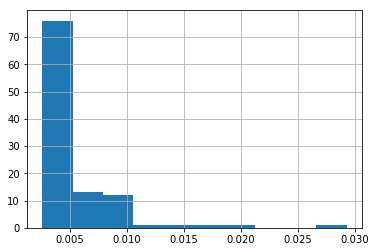

In [54]:
feature_rank_df[features_importance > 0.0025].features_importance.hist(bins=10)
plt.show()

### Number of useless features

In [55]:
useless_features = feature_rank_df.features_importance[feature_rank_df.features_importance == 0].size
total_features = feature_rank_df.size

print('{} out of {} features have no impact'.format(useless_features, total_features))

4380 out of 10688 features have no impact


# REGRESSION
Try to predict how much money a movie will make

In [56]:
movies.revenue_original.hist(bins = 40, figsize=(15, 10))

In [57]:
max_revenue = movies.revenue_original.max()
movies[movies.revenue_original == max_revenue]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,title_y,cast,crew,samuel,budget_original,popularity_original,vote_average_original,vote_count_original,revenue_original,stars
0,0.623684,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",0.171815,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",False,0.623684,0.171815,0.72,0.858057,1.0,False


In [58]:
y_reg = x.revenue.values
x_reg = x[x.columns.difference(['revenue'])]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=.2, random_state=3)

In [59]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train_reg.shape[1],)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [60]:
model.fit(X_train_reg, y_train_reg, epochs=15, batch_size=64)

Epoch 1/15
3504/3504 [==============================] - 1s 284us/step - loss: 0.0024 - mean_absolute_error: 0.0287

In [61]:
mse, mae = model.evaluate(X_test_reg, y_test_reg)

877/877 [==============================] - 0s 185us/step


In [62]:
mae

0.0168325578944679

### We are off by this dollar amount (on average)

In [63]:
mae * max_revenue

0.0168325578944679

### Try to predict a few values

In [64]:
### Value in millions
np.round(model.predict(X_test_reg[0:10]) * max_revenue / 100000)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [65]:
test_predictions = model.predict(X_test_reg)

In [66]:
compare = pd.DataFrame({
    'test_predictions': test_predictions.flatten(),
    'test_actual': y_test_reg
})

### Success of prediction

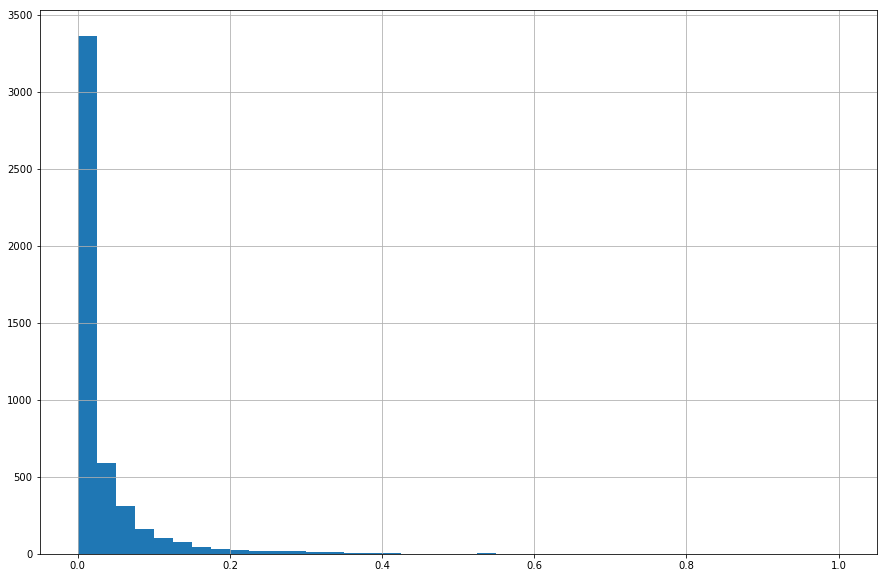

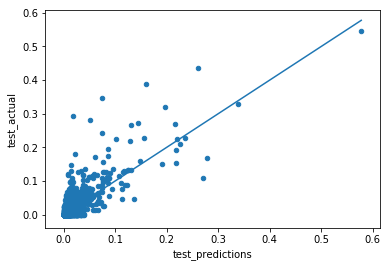

In [67]:
ax = compare.plot.scatter(x = 'test_predictions', y = 'test_actual')

_min = test_predictions.min()
_max = test_predictions.max()

ax.plot([_min, _max], [_min, _max])
plt.show()

In [68]:
# To save all movie_ids in a csv file
# movies.id.to_csv('data/movie_ids.csv', index=False)

In [69]:
movies[movies.id == 8285]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,title_y,cast,crew,samuel,budget_original,popularity_original,vote_average_original,vote_count_original,revenue_original,stars
782,0.157895,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",http://www.mycityscreams.com/,8285,"[{'id': 1308, 'name': 'secret identity'}, {'id...",en,The Spirit,Down these mean streets a man must come. A her...,0.016959,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""L...",...,The Spirit,"[{'cast_id': 6, 'character': 'The Spirit/Denny...","[{'credit_id': '52fe449cc3a36847f809fee7', 'de...",True,0.157895,0.016959,0.47,0.023269,0.014,True
